# Prediction Training

In [1]:
import pandas as pd
import datetime as td
import  numpy as np
import datetime 
import datetime as dt
import numpy as np
import sys


In [2]:
dub_forecastRaw = pd.read_csv('forecastData/dub_Forecast.csv')
don_forecastRaw = pd.read_csv('forecastData/don_Forecast.csv')
cla_forecastRaw = pd.read_csv('forecastData/cla_Forecast.csv')
cor_forecastRaw = pd.read_csv('forecastData/cor_Forecast.csv')

dub_forecastRaw['date']=pd.to_datetime(dub_forecastRaw.date)
don_forecastRaw['date']=pd.to_datetime(don_forecastRaw.date)
cla_forecastRaw['date']=pd.to_datetime(cla_forecastRaw.date)
cor_forecastRaw['date']=pd.to_datetime(cor_forecastRaw.date)


dub_forecastRaw=dub_forecastRaw.drop(['windGust'],1)
don_forecastRaw=don_forecastRaw.drop(['windGust'],1)
cla_forecastRaw=cla_forecastRaw.drop(['windGust'],1)
cor_forecastRaw=cor_forecastRaw.drop(['windGust'],1)

dub_forecastRaw.columns=['date','dub_temp','dub_wddir','dub_wdsp','dub_hum','dub_msl']
don_forecastRaw.columns=['date','don_temp','don_wddir','don_wdsp','don_hum','don_msl']

/tmp/ipykernel_181545/1295701575.py:12: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  dub_forecastRaw=dub_forecastRaw.drop(['windGust'],1)
/tmp/ipykernel_181545/1295701575.py:13: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  don_forecastRaw=don_forecastRaw.drop(['windGust'],1)
/tmp/ipykernel_181545/1295701575.py:14: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  cla_forecastRaw=cla_forecastRaw.drop(['windGust'],1)
/tmp/ipykernel_181545/1295701575.py:15: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  cor_forecastRaw=cor_forecastRaw.drop(['windGust'],1)


In [3]:
dub_forecastRaw = pd.read_csv('forecastData/dub_Forecast.csv')
don_forecastRaw = pd.read_csv('forecastData/don_Forecast.csv')
cla_forecastRaw = pd.read_csv('forecastData/cla_Forecast.csv')
cor_forecastRaw = pd.read_csv('forecastData/cor_Forecast.csv')

dub_forecastRaw['date']=pd.to_datetime(dub_forecastRaw.date)
don_forecastRaw['date']=pd.to_datetime(don_forecastRaw.date)
cla_forecastRaw['date']=pd.to_datetime(cla_forecastRaw.date)
cor_forecastRaw['date']=pd.to_datetime(cor_forecastRaw.date)


dub_forecastRaw=dub_forecastRaw.drop(['windGust'],1)
don_forecastRaw=don_forecastRaw.drop(['windGust'],1)
cla_forecastRaw=cla_forecastRaw.drop(['windGust'],1)
cor_forecastRaw=cor_forecastRaw.drop(['windGust'],1)

dub_forecastRaw.columns=['date','dub_temp','dub_wddir','dub_wdsp','dub_hum','dub_msl']
don_forecastRaw.columns=['date','don_temp','don_wddir','don_wdsp','don_hum','don_msl']
cla_forecastRaw.columns=['date','cla_temp','cla_wddir','cla_wdsp','cla_hum','cla_msl']
cor_forecastRaw.columns=['date','cor_temp','cor_wddir','cor_wdsp','cor_hum','cor_msl']

forecast = pd.merge(dub_forecastRaw ,pd.merge(don_forecastRaw ,pd.merge(cla_forecastRaw,cor_forecastRaw,on='date') ,on = 'date') ,on = 'date')



#forecast=forecastRaw.drop(['windGust'],1)
forecast= forecast.dropna()
forecast=forecast._convert(numeric=True)
rawTemp=forecast['dub_temp']

/tmp/ipykernel_181545/509841821.py:12: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  dub_forecastRaw=dub_forecastRaw.drop(['windGust'],1)
/tmp/ipykernel_181545/509841821.py:13: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  don_forecastRaw=don_forecastRaw.drop(['windGust'],1)
/tmp/ipykernel_181545/509841821.py:14: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  cla_forecastRaw=cla_forecastRaw.drop(['windGust'],1)
/tmp/ipykernel_181545/509841821.py:15: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  cor_forecastRaw=cor_forecastRaw.drop(['windGust'],1)


In [4]:


#Just taking the columns used in prediction
finalCols= ['date','dub_temp','dub_wddir','dub_wdsp','dub_msl','don_temp','don_wddir','don_wdsp','don_msl','cla_temp','cla_wddir','cla_wdsp','cla_msl','cor_temp','cor_wddir','cor_wdsp','cor_msl']
forecast = forecast[finalCols]

train_mean = np.loadtxt("./models/train_meanSave.csv",delimiter=',')
train_std = np.loadtxt("./models/train_stdSave.csv",delimiter=',')



forecast['date']=pd.to_datetime(forecast.date)

dateCol=forecast['date']
forecast=forecast.drop('date',1)


forecast = (forecast - train_mean) / train_std

forecast['date']=dateCol
forecast["dayInMonth"] =forecast['date'].dt.day

## Need to add a cos function for day of week
import math as ma
forecast['hour']=forecast['date'].dt.hour
forecast['dayOfWeek']=forecast['date'].dt.day_of_week
forecast['dayOfYear']=forecast['date'].dt.day_of_year

forecast["sin_hour"]=np.sin(forecast["hour"]/24*2*ma.pi)
forecast["sin_day"]=np.sin(forecast["dayOfYear"]/365*(2*ma.pi))


forecast["cos_hour"]=np.sin(forecast["hour"]/24*2*ma.pi)
forecast["cos_day"]=np.sin(forecast["dayOfYear"]/365*(2*ma.pi))


/tmp/ipykernel_181545/3022882954.py:13: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  forecast=forecast.drop('date',1)


In [5]:
# make sure to set this identially when creating ml model
usedCols=['sin_day','sin_hour','cos_day','cos_hour','dub_wddir','dub_wdsp','dub_temp','dub_msl',
    'don_wddir','don_wdsp','don_temp','don_msl',
    'cla_wddir','cla_wdsp','cla_temp','cla_msl',
    'cor_wddir','cor_wdsp','cor_temp','cor_msl']

### Using tensorflow make dataset

In [6]:
def make_dataset(self, data):
  data = np.array(data, dtype=np.float32)
  ds = tf.keras.utils.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=True,
      batch_size=32,)

  ds = ds.map(self.split_window)

  return ds

In [7]:
@property
def val(self):
  return self.make_dataset(self.val_df3)

### Importing the model

In [8]:
import tensorflow as tf
conv_model = tf.keras.models.load_model('models/conv_model')

# Check its architecture
conv_model.summary()

2022-08-02 14:48:10.684608: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-08-02 14:48:10.684668: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-08-02 14:48:13.542243: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-08-02 14:48:13.542319: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-08-02 14:48:13.542350: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (x20217366): /proc/driver/nvidia/version does not exist


Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_3 (Conv1D)           (None, None, 32)          1312      
                                                                 
 dense_10 (Dense)            (None, None, 32)          1056      
                                                                 
 dense_11 (Dense)            (None, None, 1)           33        
                                                                 
Total params: 2,401
Trainable params: 2,401
Non-trainable params: 0
_________________________________________________________________


In [9]:
forecastData= forecast.drop(['date','dayInMonth','hour','dayOfWeek','dayOfYear'],1)
forecastData= forecastData[usedCols]

/tmp/ipykernel_181545/3971932739.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  forecastData= forecast.drop(['date','dayInMonth','hour','dayOfWeek','dayOfYear'],1)


In [10]:
def make_dataset( data):
    data = np.array(data, dtype=np.float32)
    print("Data is  given by",data.shape)
    inputData=data
    print("Input data is given by", inputData.shape)

    ds = tf.keras.utils.timeseries_dataset_from_array(
        inputData,
        targets=None,
        sequence_length=24,
        sequence_stride=1,
        shuffle=False,
        batch_size=32,)
    print("ds is given by ",ds)
    #ds = ds.map(self.split_window)

    return ds

In [11]:
forecastDs=make_dataset(forecastData)

Data is  given by (108, 20)
Input data is given by (108, 20)
ds is given by  <BatchDataset element_spec=TensorSpec(shape=(None, None, 20), dtype=tf.float32, name=None)>


In [12]:
forecastDs=make_dataset(forecastData)
forecastArr=conv_model.predict(forecastDs)

Data is  given by (108, 20)
Input data is given by (108, 20)
ds is given by  <BatchDataset element_spec=TensorSpec(shape=(None, None, 20), dtype=tf.float32, name=None)>
3/3 [==============================] - 0s 10ms/step


In [13]:
#Finding the rolling average
forecastPred=forecastArr[:,1]

forecastpd=pd.Series(forecastPred.ravel())
forecastRoll=forecastpd.rolling(8, center =True).mean()
forecastAvg=forecastRoll.dropna().mean()
forecastRoll=forecastRoll.fillna(forecastpd)

In [14]:
#Finding the rolling average
forecastpd=pd.Series(forecastPred.ravel())
forecastRoll=forecastpd.rolling(8, center =True).mean()
forecastAvg=forecastRoll.dropna().mean()
# I had been filling values with the average, now i fill them with the original entries!
forecastRoll=forecastRoll.fillna(forecastpd)

#Finding the rolling minima
rollMin=forecastRoll.rolling(12, center=True).max()
rollMin=rollMin.fillna(forecastRoll.mean())

highlights=(rollMin== forecastRoll)
highlights[0]=False
#highlights[1]=False
highlights[highlights]

20    True
50    True
71    True
dtype: bool

/tmp/ipykernel_181545/2644998304.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  forecastPlot['index']=range(len(forecastPlot))


Itererating with I and J 0 0
Itererating with I and J 1 0
Itererating with I and J 2 0
Itererating with I and J 3 0
Itererating with I and J 4 0
Itererating with I and J 5 0
Itererating with I and J 6 0
Itererating with I and J 7 0
Itererating with I and J 8 0
Itererating with I and J 9 0
Itererating with I and J 10 0
Itererating with I and J 11 0
Itererating with I and J 12 0
Itererating with I and J 13 0
Itererating with I and J 14 0
Itererating with I and J 15 0
Itererating with I and J 16 0
Itererating with I and J 17 0
Itererating with I and J 18 0
Itererating with I and J 19 0
Itererating with I and J 20 0
Plotting with i and j are given by 20 1 And the date-time being 2022-07-19 12:00:00+00:00
Itererating with I and J 22 1
Itererating with I and J 23 0
Itererating with I and J 24 0
Itererating with I and J 25 0
Itererating with I and J 26 0
Itererating with I and J 27 0
Itererating with I and J 28 0
Itererating with I and J 29 0
Itererating with I and J 30 0
Itererating with I a

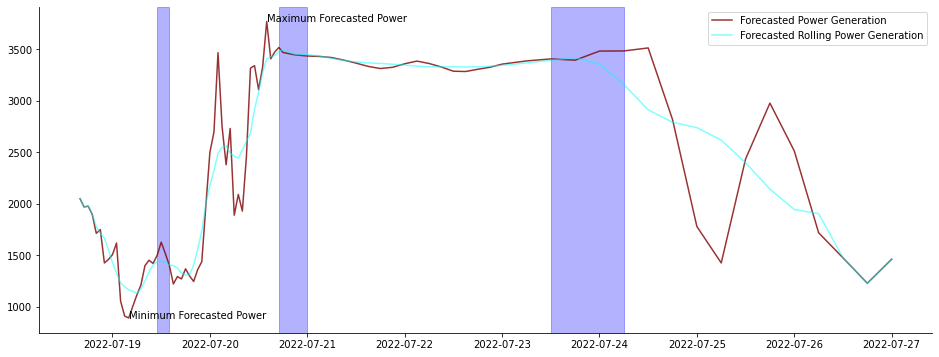

In [15]:
import matplotlib.pyplot as plt 
from matplotlib.pyplot import figure

forecastPlot=forecast.iloc[23:]
forecastPlot['index']=range(len(forecastPlot))
forecastPlot.index=range(len(forecastPlot))
forecastPlot.set_index('index')

forecastPlot= forecastPlot.reindex()


forecastPlot['predictedGeneration'] = forecastPred

fig, ax = plt.subplots(figsize=(2, 2))

plt.plot(forecastPlot['date'],forecastPred,color = 'maroon',label = 'Forecasted Power Generation', alpha = 0.8)
plt.plot(forecastPlot['date'],forecastRoll,color = 'cyan',label = 'Forecasted Rolling Power Generation', alpha = 0.5)
forcastLen=len(forecastPlot['date'])
# highlight a time range

plt.legend(bbox_to_anchor=(1, 1))


# Removing spines
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)


#Showing the maxima minima
plt.annotate("Maximum Forecasted Power", (forecastPlot.date[(forecastpd == max(forecastpd))].values[0], forecastpd[(forecastpd == max(forecastpd))].values[0]))
plt.annotate("Minimum Forecasted Power", (forecastPlot.date[(forecastpd == min(forecastpd))].values[0], forecastpd[(forecastpd == min(forecastpd))].values[0]))


#ax.axvspan(forecastPlot['date'][0],forecastPlot['date'][2], color="blue", alpha=0.3)
i=0
j=0
while i < forcastLen:
    print("Itererating with I and J",i,j)
    j = 0

    while ((i+j) <= forcastLen) and ( highlights[i]):
        if (i+j != forcastLen) and (highlights[i+j]):
            j=j+1
        elif(i+j != forcastLen):
            print("Plotting with i and j are given by",i,j,"And the date-time being",forecastPlot['date'][i])
            ax.axvspan(forecastPlot['date'][i-1],forecastPlot['date'][j+i+1], color="blue", alpha=0.3)
            i = i+j
        else:
            print("Plotting with i and j are given by",i,j,"And the date-time being",forecastPlot['date'][i])
            ax.axvspan(forecastPlot['date'][i-1],forecastPlot['date'][i], color="blue", alpha=0.3)
            i = i+j
    i=i+1
        
forecastPlot['rawTemp']=rawTemp
forecastPlot.to_csv(path_or_buf='./dashboard/chargeTimeDashboard/forecastPlot.csv',index=False)

#plt.legend(bbox_to_anchor=(0.89, 0.98))
plt.legend(loc=1)

fig = plt.gcf()
fig.set_size_inches(16, 6)
fig.savefig('./dashboard/chargeTimeDashboard/forecast.png', dpi=100)


In [16]:
'''import matplotlib.pyplot as plt 
from matplotlib.pyplot import figure

forecastPlot=forecast.iloc[2:]
forecastPlot['index']=range(len(forecastPlot))
forecastPlot.index=range(len(forecastPlot))
forecastPlot.set_index('index')

forecastPlot= forecastPlot.reindex()


forecastPlot['predictedGeneration'] = forecastPred

fig, ax = plt.subplots(figsize=(4, 4))

plt.plot(forecastPlot['date'],forecastPred,color = 'blue')
plt.plot(forecastPlot['date'],forecastRoll,color = 'cyan')
forcastLen=len(forecastPlot['date'])
# highlight a time range

#ax.axvspan(forecastPlot['date'][0],forecastPlot['date'][2], color="blue", alpha=0.3)
i=0
j=0
while i < forcastLen:
    print("Itererating with I and J",i,j)
    j = 0

    while ((i+j) <= forcastLen) and ( highlights[i]):
        if (i+j != forcastLen) and (highlights[i+j]):
            j=j+1
        elif(i+j != forcastLen):
            print("Plotting with i and j are given by",i,j,"And the date-time being",forecastPlot['date'][i])
            ax.axvspan(forecastPlot['date'][i-1],forecastPlot['date'][j+i+1], color="blue", alpha=0.3)
            i = i+j
        else:
            print("Plotting with i and j are given by",i,j,"And the date-time being",forecastPlot['date'][i])
            ax.axvspan(forecastPlot['date'][i-1],forecastPlot['date'][i], color="blue", alpha=0.3)
            i = i+j
    i=i+1
        
forecastPlot['rawTemp']=rawTemp
forecastPlot.to_csv(path_or_buf='./dashboard/chargeTimeDashboard/forecastPlot.csv',index=False)


fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
fig.savefig('forecast.png', dpi=100)
'''

'import matplotlib.pyplot as plt \nfrom matplotlib.pyplot import figure\n\nforecastPlot=forecast.iloc[2:]\nforecastPlot[\'index\']=range(len(forecastPlot))\nforecastPlot.index=range(len(forecastPlot))\nforecastPlot.set_index(\'index\')\n\nforecastPlot= forecastPlot.reindex()\n\n\nforecastPlot[\'predictedGeneration\'] = forecastPred\n\nfig, ax = plt.subplots(figsize=(4, 4))\n\nplt.plot(forecastPlot[\'date\'],forecastPred,color = \'blue\')\nplt.plot(forecastPlot[\'date\'],forecastRoll,color = \'cyan\')\nforcastLen=len(forecastPlot[\'date\'])\n# highlight a time range\n\n#ax.axvspan(forecastPlot[\'date\'][0],forecastPlot[\'date\'][2], color="blue", alpha=0.3)\ni=0\nj=0\nwhile i < forcastLen:\n    print("Itererating with I and J",i,j)\n    j = 0\n\n    while ((i+j) <= forcastLen) and ( highlights[i]):\n        if (i+j != forcastLen) and (highlights[i+j]):\n            j=j+1\n        elif(i+j != forcastLen):\n            print("Plotting with i and j are given by",i,j,"And the date-time bein

In [17]:
forecastPlot

,dub_temp,dub_wddir,dub_wdsp,dub_msl,don_temp,don_wddir,don_wdsp,don_msl,cla_temp,cla_wddir,...,hour,dayOfWeek,dayOfYear,sin_hour,sin_day,cos_hour,cos_day,index,predictedGeneration,rawTemp
0,-0.838022,16.132462,-0.759177,-0.000009,-0.861241,10.982019,-0.643278,0.000077,-0.847652,15.156950,...,16,0,199,-8.660254e-01,-0.280231,-8.660254e-01,-0.280231,0,2047.588623,25.5
1,-0.846709,11.595285,-0.759177,-0.000502,-0.871153,14.607174,-0.920728,-0.000319,-0.851769,15.385478,...,17,0,199,-9.659258e-01,-0.280231,-9.659258e-01,-0.280231,1,1967.345093,NaN
2,-0.861016,10.055519,-0.658834,-0.000897,-0.884037,3.270079,-0.871184,-0.000714,-0.859489,14.916995,...,18,0,199,-1.000000e+00,-0.280231,-1.000000e+00,-0.280231,2,1975.093628,NaN
3,-0.872768,9.614120,-0.618697,-0.001390,-0.891471,4.206917,-0.871184,-0.001011,-0.868754,15.396904,...,19,0,199,-9.659258e-01,-0.280231,-9.659258e-01,-0.280231,3,1896.478149,NaN
4,-0.887076,7.797196,-0.719040,-0.001587,-0.889489,5.075868,-0.831548,-0.001406,-0.877504,16.128195,...,20,0,199,-8.660254e-01,-0.280231,-8.660254e-01,-0.280231,4,1711.538330,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
80,-0.937151,27.927069,-0.468183,-0.002475,-0.931116,21.742076,-0.197376,-0.000912,-0.932061,36.432933,...,0,1,207,0.000000e+00,-0.409356,0.000000e+00,-0.409356,80,2511.314209,NaN
81,-0.934085,27.906539,-0.448114,-0.001390,-0.932107,21.647034,-0.157740,0.000472,-0.937208,33.404933,...,6,1,207,1.000000e+00,-0.409356,1.000000e+00,-0.409356,81,1716.894165,21.4
82,-0.912113,30.657588,-0.387908,0.001076,-0.930125,21.470529,-0.286556,0.003833,-0.914047,35.484541,...,12,1,207,1.224647e-16,-0.409356,1.224647e-16,-0.409356,82,1473.718506,NaN
83,-0.909558,32.474512,-0.618697,0.003346,-0.931116,21.029264,-0.346010,0.006304,-0.916620,34.067665,...,18,1,207,-1.000000e+00,-0.409356,-1.000000e+00,-0.409356,83,1226.816406,NaN


## Combination with the electricity-Prices dataset

In [18]:
ePrice = pd.read_csv('forecastData/ePrice.csv')
ePrice.columns= ['date', 'EndTime', 'NetImbalanceVolume','ImbalanceSettlementPrice']
ePrice['date'] =  pd.to_datetime(ePrice['date'])
ePrice=ePrice._convert(numeric=True)


ePrice = ePrice[ePrice['NetImbalanceVolume'].notna()]
ePrice = ePrice[ePrice['ImbalanceSettlementPrice'].notna()]
ePrice

,date,EndTime,NetImbalanceVolume,ImbalanceSettlementPrice
0,2022-05-27 00:00:00,2022-05-27T00:30:00,-29.291,74.45
1,2022-05-27 00:30:00,2022-05-27T01:00:00,-23.329,82.32
2,2022-05-27 01:00:00,2022-05-27T01:30:00,-36.292,52.02
3,2022-05-27 01:30:00,2022-05-27T02:00:00,-42.894,-107.00
4,2022-05-27 02:00:00,2022-05-27T02:30:00,-33.407,43.87
...,...,...,...,...
1731,2022-07-21 21:30:00,2022-07-21T22:00:00,-4.332,228.24
1732,2022-07-21 22:00:00,2022-07-21T22:30:00,-12.226,187.56
1733,2022-07-21 22:30:00,2022-07-21T23:00:00,-12.565,189.09
1734,2022-07-21 23:00:00,2022-07-21T23:30:00,-6.452,208.56


### Integrating datasets together

In [19]:
import pandas as pd
import datetime as td
import  numpy as np
weatherMerged = pd.read_csv('data/weatherMerged.csv')
weatherMerged['date']=pd.to_datetime(weatherMerged.date2)
finalCols= ['date','dub_temp','dub_wddir','dub_wdsp','dub_msl','don_temp','don_wddir','don_wdsp','don_msl','cla_temp','cla_wddir','cla_wdsp','cla_msl','cor_temp','cor_wddir','cor_wdsp','cor_msl']

#Only creating predictions for dates which are available
ePriceWeatherMerged=pd.merge(weatherMerged, ePrice,  how='outer', on='date')
ePriceWeatherMerged = ePriceWeatherMerged[ePriceWeatherMerged['ImbalanceSettlementPrice'].notna()]
ePriceWeatherMerged = ePriceWeatherMerged[ePriceWeatherMerged['date2'].notna()]
ePriceWeatherMerged=ePriceWeatherMerged.reset_index()
finalForecast = ePriceWeatherMerged[finalCols]
ePriceWeatherMerged['date'].dt.day.unique()
finalForecast = ePriceWeatherMerged[finalCols]

finalForecast= finalForecast.reindex()
finalForecast

finalForecast['date']=pd.to_datetime(finalForecast.date)

dateCol=finalForecast['date']
finalForecast=finalForecast.drop('date',1)


finalForecast = (finalForecast - train_mean) / train_std

finalForecast['date']=dateCol
finalForecast["dayInMonth"] =finalForecast['date'].dt.day

## Need to add a cos function for day of week
import math as ma
finalForecast['hour']=finalForecast['date'].dt.hour
forecast['dayOfWeek']=finalForecast['date'].dt.day_of_week
finalForecast['dayOfYear']=finalForecast['date'].dt.day_of_year

finalForecast["sin_hour"]=np.sin(finalForecast["hour"]/24*2*ma.pi)
finalForecast["sin_day"]=np.sin(finalForecast["dayOfYear"]/365*(2*ma.pi))


finalForecast["cos_hour"]=np.sin(finalForecast["hour"]/24*2*ma.pi)
finalForecast["cos_day"]=np.sin(finalForecast["dayOfYear"]/365*(2*ma.pi))

finalForecastTransformed = finalForecast

#finalForecast 

/tmp/ipykernel_181545/277294553.py:4: DtypeWarning: Columns (3,4,5,39,41,111,123,131,133,135,136,137,138,139,141,143) have mixed types. Specify dtype option on import or set low_memory=False.
  weatherMerged = pd.read_csv('data/weatherMerged.csv')
/tmp/ipykernel_181545/277294553.py:23: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  finalForecast=finalForecast.drop('date',1)


In [20]:
finalForecastTransformed

,dub_temp,dub_wddir,dub_wdsp,dub_msl,don_temp,don_wddir,don_wdsp,don_msl,cla_temp,cla_wddir,...,cor_wdsp,cor_msl,date,dayInMonth,hour,dayOfYear,sin_hour,sin_day,cos_hour,cos_day
0,-0.958100,25.689276,0.103772,0.010646,-0.947470,18.008302,1.179967,0.008676,-0.951619,28.708677,...,-0.019675,0.011762,2022-05-27 00:00:00,27,0,147,0.000000,0.573772,0.000000,0.573772
1,-0.959633,24.662766,0.003429,0.010942,-0.945983,18.008302,1.279056,0.008874,-0.952134,29.851318,...,-0.108795,0.012157,2022-05-27 01:00:00,27,1,147,0.258819,0.573772,0.258819,0.573772
2,-0.961166,24.662766,0.003429,0.011238,-0.946479,18.008302,1.179967,0.009071,-0.954193,27.566036,...,-0.376157,0.012354,2022-05-27 02:00:00,27,2,147,0.500000,0.573772,0.500000,0.573772
3,-0.961166,25.689276,0.103772,0.011337,-0.946479,17.329434,1.279056,0.009368,-0.949560,26.423394,...,-0.732639,0.012452,2022-05-27 03:00:00,27,3,147,0.707107,0.573772,0.707107,0.573772
4,-0.964743,25.689276,0.003429,0.011534,-0.947470,17.329434,1.179967,0.009862,-0.949560,28.708677,...,-0.732639,0.012551,2022-05-27 04:00:00,27,4,147,0.866025,0.573772,0.866025,0.573772
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
477,-0.919267,17.477191,0.304458,-0.008592,-0.931612,12.577359,0.684520,-0.009511,-0.920223,25.280753,...,0.069445,-0.007949,2022-06-28 19:00:00,28,19,179,-0.965926,0.060213,-0.965926,0.060213
478,-0.922332,17.477191,0.204115,-0.008296,-0.927647,12.577359,0.387251,-0.008720,-0.923826,24.138111,...,0.158566,-0.007850,2022-06-28 20:00:00,28,20,179,-0.866025,0.060213,-0.866025,0.060213
479,-0.928975,19.530213,0.103772,-0.007704,-0.933098,13.256227,-0.009106,-0.008028,-0.926914,21.852828,...,0.158566,-0.007259,2022-06-28 21:00:00,28,21,179,-0.707107,0.060213,-0.707107,0.060213
480,-0.932552,19.530213,0.605486,-0.007704,-0.938550,11.898491,-0.108195,-0.007534,-0.935664,20.710187,...,0.069445,-0.006864,2022-06-28 22:00:00,28,22,179,-0.500000,0.060213,-0.500000,0.060213


In [21]:
ann_model = tf.keras.models.load_model('models/ann_modelS')
finalForecastP=finalForecast[usedCols]
finalForecastP = np.array(finalForecastP, dtype=np.float32)
#forecastDs=make_dataset(finalForecastP)
forecastArr=ann_model.predict(finalForecastP)

16/16 [==============================] - 0s 2ms/step


In [22]:
forecastPred = forecastArr
forecastpd=pd.Series(forecastPred.ravel())
forecastRoll=forecastpd.rolling(6, center =True).mean()
forecastAvg=forecastRoll.dropna().mean()
forecastRoll=forecastRoll.fillna(forecastpd)

#Finding the rolling average
forecastpd=pd.Series(forecastPred.ravel())
forecastRoll=forecastpd.rolling(6, center =True).mean()
forecastAvg=forecastRoll.dropna().mean()
# I had been filling values with the average, now i fill them with the original entries!
forecastRoll=forecastRoll.fillna(forecastpd)

#Finding the rolling minima
rollMin=forecastRoll.rolling(6, center=True).max()
rollMin=rollMin.fillna(forecastRoll.mean())

highlights=(rollMin== forecastRoll)
highlights[0]=False
#highlights[1]=False
highlights[highlights]
print(len(highlights[highlights]))

print(len(highlights))

34
482


In [23]:
ePriceWeatherMerged['highlightsBesidePeakWind'] = highlights
ePriceWeatherMerged['highlights'] = highlights
ePriceWeatherMerged['highlightsHourlyMorning'] = highlights
#ePriceWeatherMerged = ePriceWeatherMerged.reset_index()
hours = ePriceWeatherMerged['date'].dt.hour

ePriceWeatherMerged['hours'] = hours
for i in range(len(ePriceWeatherMerged)):
    if (hours[i] <8):
        ePriceWeatherMerged.loc[i,'highlightsHourlyMorning'] = True
    else:
        ePriceWeatherMerged.loc[i,'highlightsHourlyMorning'] = False
    if(highlights[i]):
        ePriceWeatherMerged.loc[i-3:i+3,'highlightsBesidePeakWind'] =True
        print(i)
ePriceWeatherMerged = ePriceWeatherMerged[ePriceWeatherMerged['highlights'].notna()]

highlightsBesidePeakWind=ePriceWeatherMerged['highlightsBesidePeakWind']
highlightsHourlyMorning=ePriceWeatherMerged['highlightsHourlyMorning']

11
18
38
48
52
66
90
96
105
115
125
132
162
178
204
219
229
247
250
261
268
281
296
304
322
332
344
354
381
396
412
429
459
475


In [24]:
ePriceWeatherMerged.ImbalanceSettlementPrice[highlightsBesidePeakWind].mean()

200.38604347826083

## Attempt 2

In [25]:
len(train_mean)

16

In [26]:
import pandas as pd
import datetime as td
import  numpy as np
weatherMerged = pd.read_csv('data/weatherMerged.csv')
weatherMerged['date']=pd.to_datetime(weatherMerged.date2)
#finalCols= ['date','dub_temp','dub_wddir','dub_wdsp','dub_msl','don_temp','don_wddir','don_wdsp','don_msl','cla_temp','cla_wddir','cla_wdsp','cla_msl','cor_temp','cor_wddir','cor_wdsp','cor_msl']
usedColsForecast=['dub_wddir','dub_wdsp','dub_temp','dub_msl',
    'don_wddir','don_wdsp','don_temp','don_msl',
    'cla_wddir','cla_wdsp','cla_temp','cla_msl',
    'cor_wddir','cor_wdsp','cor_temp','cor_msl']



#Only creating predictions for dates which are available
ePriceWeatherMerged=pd.merge(ePrice, weatherMerged, how='outer', on='date')

ePriceWeatherMerged = ePriceWeatherMerged[ePriceWeatherMerged['ImbalanceSettlementPrice'].notna()]
ePriceWeatherMerged = ePriceWeatherMerged[ePriceWeatherMerged['date2'].notna()]

ePriceWeatherMerged['date']=pd.to_datetime(ePriceWeatherMerged.date)
dateCol=ePriceWeatherMerged['date']

finalForecast = ePriceWeatherMerged[usedColsForecast]

ePrice = ePrice[ePrice['ImbalanceSettlementPrice'].notna()]


# make sure to set this identially when creating ml model

allCols=['sin_day','sin_hour','cos_day','cos_hour',
        'dub_wddir','dub_wdsp','dub_temp','dub_msl',
        'don_wddir','don_wdsp','don_temp','don_msl',
        'cla_wddir','cla_wdsp','cla_temp','cla_msl',
        'cor_wddir','cor_wdsp','cor_temp','cor_msl']

finalForecast = ePriceWeatherMerged[usedColsForecast]

ePrice = ePrice[ePrice['ImbalanceSettlementPrice'].notna()]

finalForecast= finalForecast.reindex()

#finalForecast=finalForecast.drop('date',0)


finalForecast = (finalForecast - train_mean) / train_std

finalForecast['date']=dateCol
finalForecast["dayInMonth"] =finalForecast['date'].dt.day

## Need to add a cos function for day of week
import math as ma
finalForecast['hour']=finalForecast['date'].dt.hour
forecast['dayOfWeek']=finalForecast['date'].dt.day_of_week
finalForecast['dayOfYear']=finalForecast['date'].dt.day_of_year

finalForecast["sin_hour"]=np.sin(finalForecast["hour"]/24*2*ma.pi)
finalForecast["sin_day"]=np.sin(finalForecast["dayOfYear"]/365*(2*ma.pi))


finalForecast["cos_hour"]=np.sin(finalForecast["hour"]/24*2*ma.pi)
finalForecast["cos_day"]=np.sin(finalForecast["dayOfYear"]/365*(2*ma.pi))


finalForecastTransformed = finalForecast
finalForecastTransformed

/tmp/ipykernel_181545/3208401575.py:4: DtypeWarning: Columns (3,4,5,39,41,111,123,131,133,135,136,137,138,139,141,143) have mixed types. Specify dtype option on import or set low_memory=False.
  weatherMerged = pd.read_csv('data/weatherMerged.csv')


,dub_wddir,dub_wdsp,dub_temp,dub_msl,don_wddir,don_wdsp,don_temp,don_msl,cla_wddir,cla_wdsp,...,cor_temp,cor_msl,date,dayInMonth,hour,dayOfYear,sin_hour,sin_day,cos_hour,cos_day
0,0.328523,0.129162,-0.177188,0.010646,0.387587,0.493509,0.050348,0.008676,0.338196,-0.314415,...,-0.019675,0.011762,2022-05-27 00:00:00,27,0,147,0.000000,0.573772,0.000000,0.573772
2,0.277426,0.026511,-0.207291,0.010942,0.387587,0.561396,0.080074,0.008874,0.389665,-0.428679,...,-0.055323,0.012157,2022-05-27 01:00:00,27,1,147,0.258819,0.573772,0.258819,0.573772
4,0.277426,0.026511,-0.237394,0.011238,0.387587,0.493509,0.070165,0.009071,0.286727,-0.657208,...,-0.082059,0.012354,2022-05-27 02:00:00,27,2,147,0.500000,0.573772,0.500000,0.573772
6,0.328523,0.129162,-0.237394,0.011337,0.33803,0.561396,0.070165,0.009368,0.235258,-0.542943,...,-0.135532,0.012452,2022-05-27 03:00:00,27,3,147,0.707107,0.573772,0.707107,0.573772
8,0.328523,0.026511,-0.307634,0.011534,0.33803,0.493509,0.050348,0.009862,0.338196,-0.542943,...,-0.171180,0.012551,2022-05-27 04:00:00,27,4,147,0.866025,0.573772,0.866025,0.573772
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
954,-0.080253,0.334464,0.585418,-0.008592,-0.008866,0.154075,0.367434,-0.009511,0.183789,0.485434,...,0.167478,-0.007949,2022-06-28 19:00:00,28,19,179,-0.965926,0.060213,-0.965926,0.060213
956,-0.080253,0.231813,0.525212,-0.008296,-0.008866,-0.049585,0.446705,-0.008720,0.132320,0.142641,...,0.185302,-0.007850,2022-06-28 20:00:00,28,20,179,-0.866025,0.060213,-0.866025,0.060213
958,0.021941,0.129162,0.394766,-0.007704,0.04069,-0.321132,0.337707,-0.008028,0.029381,0.028377,...,0.096182,-0.007259,2022-06-28 21:00:00,28,21,179,-0.707107,0.060213,-0.707107,0.060213
960,0.021941,0.642417,0.324526,-0.007704,-0.058423,-0.389019,0.228708,-0.007534,-0.022088,0.142641,...,0.105094,-0.006864,2022-06-28 22:00:00,28,22,179,-0.500000,0.060213,-0.500000,0.060213


In [27]:
ann_model = tf.keras.models.load_model('models/ann_modelS')

In [28]:
finalForecastP=finalForecastTransformed[usedCols]
finalForecastP = np.array(finalForecastP, dtype=np.float32)
#forecastDs=make_dataset(finalForecastP)
forecastArr=ann_model.predict(finalForecastP)

16/16 [==============================] - 0s 2ms/step


In [29]:
forecastPred = forecastArr
forecastpd=pd.Series(forecastPred.ravel())
forecastRoll=forecastpd.rolling(6, center =True).mean()
forecastAvg=forecastRoll.dropna().mean()
forecastRoll=forecastRoll.fillna(forecastpd)

#Finding the rolling average
forecastpd=pd.Series(forecastPred.ravel())
forecastRoll=forecastpd.rolling(6, center =True).mean()
forecastAvg=forecastRoll.dropna().mean()
# I had been filling values with the average, now i fill them with the original entries!
forecastRoll=forecastRoll.fillna(forecastpd)

#Finding the rolling minima
rollMin=forecastRoll.rolling(6, center=True).max()
rollMin=rollMin.fillna(forecastRoll.mean())

highlights=(rollMin== forecastRoll)
highlights[0]=False
#highlights[1]=False
highlights[highlights]
print(len(highlights[highlights]))

print(len(highlights))

26
482


In [30]:
ePriceWeatherMerged['highlightsBesidePeakWind'] = highlights
ePriceWeatherMerged['highlights'] = highlights
ePriceWeatherMerged['highlightsHourlyMorning'] = highlights
ePriceWeatherMerged = ePriceWeatherMerged.reset_index()
hours = ePriceWeatherMerged['date'].dt.hour

ePriceWeatherMerged['hours'] = hours
for i in range(len(ePriceWeatherMerged)):
    #Highlighting hours which are between 0 and 8 am
    if (hours[i] <8):
        ePriceWeatherMerged.loc[i,'highlightsHourlyMorning'] = True
    else:
        ePriceWeatherMerged.loc[i,'highlightsHourlyMorning'] = False
    if(highlights[i]):
        # This highlights the hours before and after there has been a peak in wind generation 
        ePriceWeatherMerged.loc[i-3:i+3,'highlightsBesidePeakWind'] =True
        print(i)
ePriceWeatherMerged = ePriceWeatherMerged[ePriceWeatherMerged['highlights'].notna()]

15
37
41
46
64
88
112
138
151
160
180
186
206
229
243
260
284
308
332
353
368
384
405
424
454
474


In [201]:
import math as ma
highlightsBesidePeakWind = ePriceWeatherMerged['highlightsBesidePeakWind']
highlightsS = ePriceWeatherMerged['highlights']
highlightsHourlyMorning = ePriceWeatherMerged['highlightsHourlyMorning']

# Finding the mean settlement price over the complete period
meanEPrice=ePriceWeatherMerged.ImbalanceSettlementPrice.mean()
print("Mean electricity price given by",meanEPrice)


eMinWindPeak=ePriceWeatherMerged.ImbalanceSettlementPrice[highlightsS].mean()
print("The average cost of electricity at peak wind power production is given by ", eMinWindPeak)


eMinWindPeak=ePriceWeatherMerged.ImbalanceSettlementPrice[highlightsBesidePeakWind].mean()
print("The average cost of electricity of the hours around peak wind power production ", eMinWindPeak)


eMinHoursMorning = ePriceWeatherMerged.ImbalanceSettlementPrice[highlightsHourlyMorning].mean()
print("The average cost of electricity at early morning times  ", eMinHoursMorning)

Mean electricity price given by 191.4080290456432
The average cost of electricity at peak wind power production is given by  162.72636363636366
The average cost of electricity of the hours around peak wind power production  138.9906153846154
The average cost of electricity at early morning times   175.9344375


In [33]:
mask = (ePriceWeatherMerged['date'] > '2022-6-21') & (ePriceWeatherMerged['date'] <= '2022-6-28')
#print(ePriceWeatherMerged['ForecastWind'].loc[mask])
#ePriceWeatherMerged[['ActualWind','date']]

## Completing plots

In [34]:
import pandas as pd
import datetime as td
import  numpy as np
weatherMerged = pd.read_csv('data/weatherMerged.csv')
weatherMerged['date']=pd.to_datetime(weatherMerged.date2)
#finalCols= ['date','dub_temp','dub_wddir','dub_wdsp','dub_msl','don_temp','don_wddir','don_wdsp','don_msl','cla_temp','cla_wddir','cla_wdsp','cla_msl','cor_temp','cor_wddir','cor_wdsp','cor_msl']
usedColsForecast=['dub_wddir','dub_wdsp','dub_temp','dub_msl',
    'don_wddir','don_wdsp','don_temp','don_msl',
    'cla_wddir','cla_wdsp','cla_temp','cla_msl',
    'cor_wddir','cor_wdsp','cor_temp','cor_msl']



#Only creating predictions for dates which are available
ePriceWeatherMerged=pd.merge(ePrice, weatherMerged, how='outer', on='date')

ePriceWeatherMerged = ePriceWeatherMerged[ePriceWeatherMerged['ImbalanceSettlementPrice'].notna()]
ePriceWeatherMerged = ePriceWeatherMerged[ePriceWeatherMerged['date2'].notna()]

ePriceWeatherMerged['date']=pd.to_datetime(ePriceWeatherMerged.date)
dateCol=ePriceWeatherMerged['date']

finalForecast = ePriceWeatherMerged[usedColsForecast]

ePrice = ePrice[ePrice['ImbalanceSettlementPrice'].notna()]


# make sure to set this identially when creating ml model

allCols=['sin_day','sin_hour','cos_day','cos_hour',
        'dub_wddir','dub_wdsp','dub_temp','dub_msl',
        'don_wddir','don_wdsp','don_temp','don_msl',
        'cla_wddir','cla_wdsp','cla_temp','cla_msl',
        'cor_wddir','cor_wdsp','cor_temp','cor_msl']

finalForecast = ePriceWeatherMerged[usedColsForecast]

ePrice = ePrice[ePrice['ImbalanceSettlementPrice'].notna()]

finalForecast= finalForecast.reindex()

#finalForecast=finalForecast.drop('date',0)


finalForecast = (finalForecast - train_mean) / train_std

finalForecast['date']=dateCol
finalForecast["dayInMonth"] =finalForecast['date'].dt.day

## Need to add a cos function for day of week
import math as ma
finalForecast['hour']=finalForecast['date'].dt.hour
forecast['dayOfWeek']=finalForecast['date'].dt.day_of_week
finalForecast['dayOfYear']=finalForecast['date'].dt.day_of_year

finalForecast["sin_hour"]=np.sin(finalForecast["hour"]/24*2*ma.pi)
finalForecast["sin_day"]=np.sin(finalForecast["dayOfYear"]/365*(2*ma.pi))


finalForecast["cos_hour"]=np.sin(finalForecast["hour"]/24*2*ma.pi)
finalForecast["cos_day"]=np.sin(finalForecast["dayOfYear"]/365*(2*ma.pi))


finalForecastTransformed = finalForecast


/tmp/ipykernel_181545/3782274775.py:4: DtypeWarning: Columns (3,4,5,39,41,111,123,131,133,135,136,137,138,139,141,143) have mixed types. Specify dtype option on import or set low_memory=False.
  weatherMerged = pd.read_csv('data/weatherMerged.csv')


In [35]:
ePriceWeatherMerged=ePriceWeatherMerged._convert(numeric=True)
ediff=ePriceWeatherMerged['ActualGenerationMW']-ePriceWeatherMerged['ActualWind']

#forecastPred = ediff
forecastpd=pd.Series(forecastPred.ravel())
forecastRoll=forecastpd.rolling(6, center =True).mean()
forecastAvg=forecastRoll.dropna().mean()
forecastRoll=forecastRoll.fillna(forecastpd)

#Finding the rolling average
forecastpd=pd.Series(forecastPred.ravel())
forecastRoll=forecastpd.rolling(12, center =True).mean()
forecastAvg=forecastRoll.dropna().mean()
# I had been filling values with the average, now i fill them with the original entries!
forecastRoll=forecastRoll.fillna(forecastpd)

#Finding the rolling maxima
rollMin=forecastRoll.rolling(24, center=True).max()
rollMin=rollMin.fillna(forecastRoll.mean())

highlights=(rollMin== forecastRoll)
highlights[0]=False
#highlights[1]=False
highlights[highlights]
print(len(highlights[highlights]))

print(len(highlights))
highlightsDiff = highlights

12
482


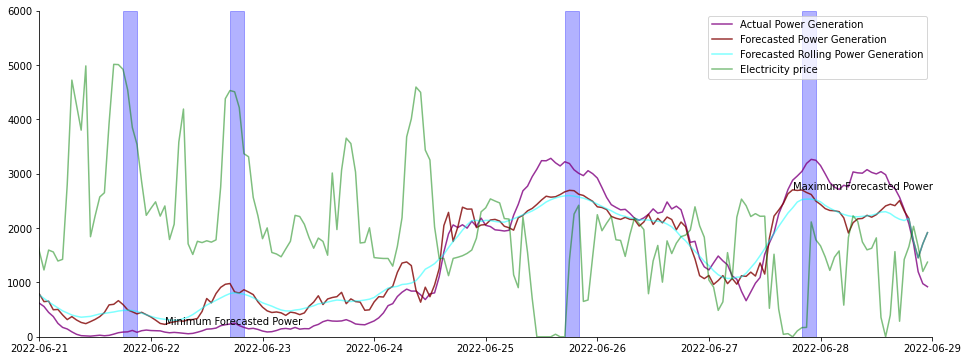

In [36]:
import matplotlib.pyplot as plt 
from matplotlib.pyplot import figure

forecastPlot=finalForecast
forecastPlot['index']=range(len(forecastPlot))
forecastPlot.index=range(len(forecastPlot))
forecastPlot.set_index('index')

ePriceWeatherMerged=ePriceWeatherMerged._convert(numeric=True)

forecastPlot= forecastPlot.reindex()


forecastPlot['predictedGeneration'] = forecastPred

fig, ax = plt.subplots(figsize=(2, 2))

plt.plot(ePriceWeatherMerged['date'],ePriceWeatherMerged[['ActualWind']],color = 'purple',label = 'Actual Power Generation', alpha = 0.8)

plt.plot(forecastPlot['date'],forecastPred,color = 'maroon',label = 'Forecasted Power Generation', alpha = 0.8)
plt.plot(forecastPlot['date'],forecastRoll,color = 'cyan',label = 'Forecasted Rolling Power Generation', alpha = 0.5)
plt.plot(forecastPlot['date'],ePriceWeatherMerged[['ImbalanceSettlementPrice']]*10,color = 'green',label = 'Electricity price', alpha = 0.5)

forcastLen=len(forecastPlot['date'])
# highlight a time range

plt.legend(bbox_to_anchor=(1, 1))


# Removing spines
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)


#Showing the maxima minima
plt.annotate("Maximum Forecasted Power", (forecastPlot.date[(forecastpd == max(forecastpd))].values[0], forecastpd[(forecastpd == max(forecastpd))].values[0]))
plt.annotate("Minimum Forecasted Power", (forecastPlot.date[(forecastpd == min(forecastpd))].values[0], forecastpd[(forecastpd == min(forecastpd))].values[0]))
ax.set_xlim([datetime.date(2022, 6, 21), datetime.date(2022, 6, 29)])
ax.set_ylim([0, 6000])

#ax.axvspan(forecastPlot['date'][0],forecastPlot['date'][2], color="blue", alpha=0.3)
i=0
j=0
while i < forcastLen:
    #print("Itererating with I and J",i,j)
    j = 0

    while ((i+j) <= forcastLen) and ( highlights[i]):
        if (i+j != forcastLen) and (highlights[i+j]):
            j=j+1
        elif(i+j != forcastLen):
            #print("Plotting with i and j are given by",i,j,"And the date-time being",forecastPlot['date'][i])
            ax.axvspan(forecastPlot['date'][i-1],forecastPlot['date'][j+i+1], color="blue", alpha=0.3)
            i = i+j
        else:
            #print("Plotting with i and j are given by",i,j,"And the date-time being",forecastPlot['date'][i])
            ax.axvspan(forecastPlot['date'][i-1],forecastPlot['date'][i], color="blue", alpha=0.3)
            i = i+j
    i=i+1
        
forecastPlot['rawTemp']=rawTemp
forecastPlot.to_csv(path_or_buf='./dashboard/chargeTimeDashboard/forecastPlot.csv',index=False)

#plt.legend(bbox_to_anchor=(0.89, 0.98))
plt.legend(loc=1)

fig = plt.gcf()
fig.set_size_inches(16, 6)
fig.savefig('./dashboard/chargeTimeDashboard/forecast.png', dpi=100)


## Model Adjustments

In [37]:
import pandas as pd
import datetime as td
import  numpy as np
weatherMerged = pd.read_csv('data/weatherMerged.csv')
weatherMerged['date']=pd.to_datetime(weatherMerged.date2)
#finalCols= ['date','dub_temp','dub_wddir','dub_wdsp','dub_msl','don_temp','don_wddir','don_wdsp','don_msl','cla_temp','cla_wddir','cla_wdsp','cla_msl','cor_temp','cor_wddir','cor_wdsp','cor_msl']
usedColsForecast=['dub_wddir','dub_wdsp','dub_temp','dub_msl',
    'don_wddir','don_wdsp','don_temp','don_msl',
    'cla_wddir','cla_wdsp','cla_temp','cla_msl',
    'cor_wddir','cor_wdsp','cor_temp','cor_msl']



#Only creating predictions for dates which are available
ePriceWeatherMerged=pd.merge(ePrice, weatherMerged, how='outer', on='date')

ePriceWeatherMerged = ePriceWeatherMerged[ePriceWeatherMerged['ImbalanceSettlementPrice'].notna()]
ePriceWeatherMerged = ePriceWeatherMerged[ePriceWeatherMerged['date2'].notna()]

ePriceWeatherMerged['date']=pd.to_datetime(ePriceWeatherMerged.date)
dateCol=ePriceWeatherMerged['date']

finalForecast = ePriceWeatherMerged[usedColsForecast]

ePrice = ePrice[ePrice['ImbalanceSettlementPrice'].notna()]


# make sure to set this identially when creating ml model

allCols=['sin_day','sin_hour','cos_day','cos_hour',
        'dub_wddir','dub_wdsp','dub_temp','dub_msl',
        'don_wddir','don_wdsp','don_temp','don_msl',
        'cla_wddir','cla_wdsp','cla_temp','cla_msl',
        'cor_wddir','cor_wdsp','cor_temp','cor_msl']

finalForecast = ePriceWeatherMerged[usedColsForecast]

ePrice = ePrice[ePrice['ImbalanceSettlementPrice'].notna()]

finalForecast= finalForecast.reindex()

#finalForecast=finalForecast.drop('date',0)


finalForecast = (finalForecast - train_mean) / train_std

finalForecast['date']=dateCol
finalForecast["dayInMonth"] =finalForecast['date'].dt.day

## Need to add a cos function for day of week
import math as ma
finalForecast['hour']=finalForecast['date'].dt.hour
forecast['dayOfWeek']=finalForecast['date'].dt.day_of_week
finalForecast['dayOfYear']=finalForecast['date'].dt.day_of_year

finalForecast["sin_hour"]=np.sin(finalForecast["hour"]/24*2*ma.pi)
finalForecast["sin_day"]=np.sin(finalForecast["dayOfYear"]/365*(2*ma.pi))


finalForecast["cos_hour"]=np.sin(finalForecast["hour"]/24*2*ma.pi)
finalForecast["cos_day"]=np.sin(finalForecast["dayOfYear"]/365*(2*ma.pi))


finalForecastTransformed = finalForecast


ePriceWeatherMerged=ePriceWeatherMerged._convert(numeric=True)
ediff=ePriceWeatherMerged['ActualGenerationMW']-ePriceWeatherMerged['ActualWind']

#forecastPred = ediff
forecastpd=pd.Series(forecastPred.ravel())
forecastRoll=forecastpd.rolling(6, center =True).mean()
forecastAvg=forecastRoll.dropna().mean()
forecastRoll=forecastRoll.fillna(forecastpd)

#Finding the rolling average
forecastpd=pd.Series(forecastPred.ravel())
forecastRoll=forecastpd.rolling(12, center =True).mean()
forecastAvg=forecastRoll.dropna().mean()
# I had been filling values with the average, now i fill them with the original entries!
forecastRoll=forecastRoll.fillna(forecastpd)

#Finding the rolling maxima
rollMin=forecastRoll.rolling(24, center=True).max()
rollMin=rollMin.fillna(forecastRoll.mean())

highlights=(rollMin== forecastRoll)
highlights[0]=False
#highlights[1]=False
highlights[highlights]
print(len(highlights[highlights]))

print(len(highlights))
highlightsDiff = highlights

/tmp/ipykernel_181545/3007565542.py:4: DtypeWarning: Columns (3,4,5,39,41,111,123,131,133,135,136,137,138,139,141,143) have mixed types. Specify dtype option on import or set low_memory=False.
  weatherMerged = pd.read_csv('data/weatherMerged.csv')


12
482


In [38]:


ePriceWeatherMerged=ePriceWeatherMerged._convert(numeric=True)
ediff=ePriceWeatherMerged['ActualGenerationMW']-ePriceWeatherMerged['ActualWind']

#forecastPred = ediff
forecastpd=pd.Series(forecastPred.ravel())
forecastRoll=forecastpd.rolling(6, center =True).mean()
forecastAvg=forecastRoll.dropna().mean()
forecastRoll=forecastRoll.fillna(forecastpd)

#Finding the rolling average
forecastpd=pd.Series(forecastPred.ravel())
forecastRoll=forecastpd.rolling(12, center =True).mean()
forecastAvg=forecastRoll.dropna().mean()
# I had been filling values with the average, now i fill them with the original entries!
forecastRoll=forecastRoll.fillna(forecastpd)

#Finding the rolling maxima
rollMin=forecastRoll.rolling(6, center=True).max()
rollMin=rollMin.fillna(forecastRoll.mean())

# Adding condition above where the rolling forecast needs to be above average the average of the last three years
highlights=(rollMin== forecastRoll) & (forecastRoll>1500 )
highlights[0]=False



#highlights[1]=False
highlights[highlights]
print(len(highlights[highlights]))

print(len(highlights))
highlightsDiff = highlights

6
482


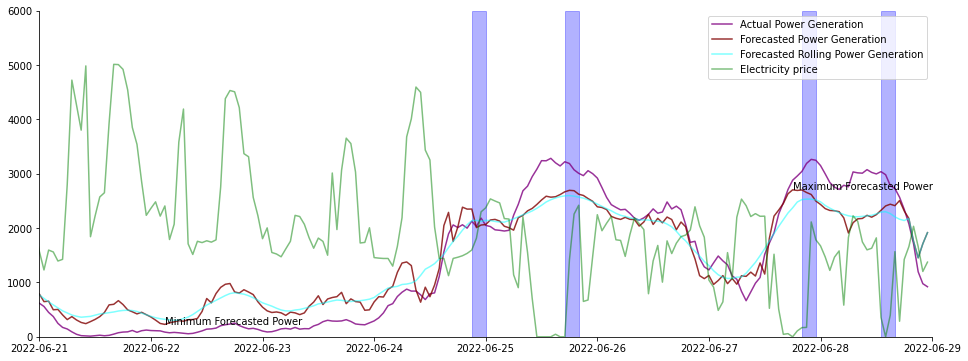

In [39]:
import matplotlib.pyplot as plt 
from matplotlib.pyplot import figure

forecastPlot=finalForecast
forecastPlot['index']=range(len(forecastPlot))
forecastPlot.index=range(len(forecastPlot))
forecastPlot.set_index('index')

ePriceWeatherMerged=ePriceWeatherMerged._convert(numeric=True)

forecastPlot= forecastPlot.reindex()


forecastPlot['predictedGeneration'] = forecastPred

fig, ax = plt.subplots(figsize=(2, 2))

plt.plot(ePriceWeatherMerged['date'],ePriceWeatherMerged[['ActualWind']],color = 'purple',label = 'Actual Power Generation', alpha = 0.8)

plt.plot(forecastPlot['date'],forecastPred,color = 'maroon',label = 'Forecasted Power Generation', alpha = 0.8)
plt.plot(forecastPlot['date'],forecastRoll,color = 'cyan',label = 'Forecasted Rolling Power Generation', alpha = 0.5)
plt.plot(forecastPlot['date'],ePriceWeatherMerged[['ImbalanceSettlementPrice']]*10,color = 'green',label = 'Electricity price', alpha = 0.5)

forcastLen=len(forecastPlot['date'])
# highlight a time range

plt.legend(bbox_to_anchor=(1, 1))


# Removing spines
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)


#Showing the maxima minima
plt.annotate("Maximum Forecasted Power", (forecastPlot.date[(forecastpd == max(forecastpd))].values[0], forecastpd[(forecastpd == max(forecastpd))].values[0]))
plt.annotate("Minimum Forecasted Power", (forecastPlot.date[(forecastpd == min(forecastpd))].values[0], forecastpd[(forecastpd == min(forecastpd))].values[0]))
ax.set_xlim([datetime.date(2022, 6, 21), datetime.date(2022, 6, 29)])
ax.set_ylim([0, 6000])

#ax.axvspan(forecastPlot['date'][0],forecastPlot['date'][2], color="blue", alpha=0.3)
i=0
j=0
while i < forcastLen:
    #print("Itererating with I and J",i,j)
    j = 0

    while ((i+j) <= forcastLen) and ( highlights[i]):
        if (i+j != forcastLen) and (highlights[i+j]):
            j=j+1
        elif(i+j != forcastLen):
            #print("Plotting with i and j are given by",i,j,"And the date-time being",forecastPlot['date'][i])
            ax.axvspan(forecastPlot['date'][i-1],forecastPlot['date'][j+i+1], color="blue", alpha=0.3)
            i = i+j
        else:
            #print("Plotting with i and j are given by",i,j,"And the date-time being",forecastPlot['date'][i])
            ax.axvspan(forecastPlot['date'][i-1],forecastPlot['date'][i], color="blue", alpha=0.3)
            i = i+j
    i=i+1
        
forecastPlot['rawTemp']=rawTemp
forecastPlot.to_csv(path_or_buf='./dashboard/chargeTimeDashboard/forecastPlot.csv',index=False)

#plt.legend(bbox_to_anchor=(0.89, 0.98))
plt.legend(loc=1)

fig = plt.gcf()
fig.set_size_inches(16, 6)
fig.savefig('./dashboard/chargeTimeDashboard/forecast.png', dpi=100)


In [40]:
import math as ma

ePriceWeatherMerged['highlightsBesidePeakWind'] = highlights
ePriceWeatherMerged['highlights'] = highlights
ePriceWeatherMerged['highlightsHourlyMorning'] = highlights
ePriceWeatherMerged = ePriceWeatherMerged.reset_index()
hours = ePriceWeatherMerged['date'].dt.hour

ePriceWeatherMerged['hours'] = hours
for i in range(len(ePriceWeatherMerged)):
    #Highlighting hours which are between 0 and 8 am
    if (hours[i] <8):
        ePriceWeatherMerged.loc[i,'highlightsHourlyMorning'] = True
    else:
        ePriceWeatherMerged.loc[i,'highlightsHourlyMorning'] = False
    if(highlights[i]):
        # This highlights the hours before and after there has been a peak in wind generation 
        ePriceWeatherMerged.loc[i-3:i+3,'highlightsBesidePeakWind'] =True
        print(i)
ePriceWeatherMerged = ePriceWeatherMerged[ePriceWeatherMerged['highlights'].notna()]



highlightsBesidePeakWind = ePriceWeatherMerged['highlightsBesidePeakWind']
highlightsS = ePriceWeatherMerged['highlights']
highlightsHourlyMorning = ePriceWeatherMerged['highlightsHourlyMorning']

# Finding the mean settlement price over the complete period
meanEPrice=ePriceWeatherMerged.ImbalanceSettlementPrice.mean()
print("Mean electricity price given by",meanEPrice)


eMinWindPeak=ePriceWeatherMerged.ImbalanceSettlementPrice[highlightsS].mean()
print("The average cost of electricity at peak wind power production is given by ", eMinWindPeak)


eMinWindPeak=ePriceWeatherMerged.ImbalanceSettlementPrice[highlightsBesidePeakWind].mean()
print("The average cost of electricity of the hours around peak wind power production ", eMinWindPeak)


eMinHoursMorning = ePriceWeatherMerged.ImbalanceSettlementPrice[highlightsHourlyMorning].mean()
print("The average cost of electricity at early morning times  ", eMinHoursMorning)

203
258
384
404
455
472
Mean electricity price given by 185.87215767634856
The average cost of electricity at peak wind power production is given by  136.8125
The average cost of electricity of the hours around peak wind power production  162.04399999999998
The average cost of electricity at early morning times   162.22175


## Final Version :- Combining time of day pricing with peak wind power production pricing

In [98]:
import pandas as pd
import datetime as td
import  numpy as np
weatherMerged = pd.read_csv('data/weatherMerged.csv')
weatherMerged['date']=pd.to_datetime(weatherMerged.date2)
#finalCols= ['date','dub_temp','dub_wddir','dub_wdsp','dub_msl','don_temp','don_wddir','don_wdsp','don_msl','cla_temp','cla_wddir','cla_wdsp','cla_msl','cor_temp','cor_wddir','cor_wdsp','cor_msl']
usedColsForecast=['dub_wddir','dub_wdsp','dub_temp','dub_msl',
    'don_wddir','don_wdsp','don_temp','don_msl',
    'cla_wddir','cla_wdsp','cla_temp','cla_msl',
    'cor_wddir','cor_wdsp','cor_temp','cor_msl']



#Only creating predictions for dates which are available
ePriceWeatherMerged=pd.merge(ePrice, weatherMerged, how='outer', on='date')

ePriceWeatherMerged = ePriceWeatherMerged[ePriceWeatherMerged['ImbalanceSettlementPrice'].notna()]
ePriceWeatherMerged = ePriceWeatherMerged[ePriceWeatherMerged['date2'].notna()]

ePriceWeatherMerged['date']=pd.to_datetime(ePriceWeatherMerged.date)
dateCol=ePriceWeatherMerged['date']

finalForecast = ePriceWeatherMerged[usedColsForecast]

ePrice = ePrice[ePrice['ImbalanceSettlementPrice'].notna()]


# make sure to set this identially when creating ml model

allCols=['sin_day','sin_hour','cos_day','cos_hour',
        'dub_wddir','dub_wdsp','dub_temp','dub_msl',
        'don_wddir','don_wdsp','don_temp','don_msl',
        'cla_wddir','cla_wdsp','cla_temp','cla_msl',
        'cor_wddir','cor_wdsp','cor_temp','cor_msl']

finalForecast = ePriceWeatherMerged[usedColsForecast]

ePrice = ePrice[ePrice['ImbalanceSettlementPrice'].notna()]

finalForecast= finalForecast.reindex()

#finalForecast=finalForecast.drop('date',0)


finalForecast = (finalForecast - train_mean) / train_std

finalForecast['date']=dateCol
finalForecast["dayInMonth"] =finalForecast['date'].dt.day

## Need to add a cos function for day of week
import math as ma
finalForecast['hour']=finalForecast['date'].dt.hour
forecast['dayOfWeek']=finalForecast['date'].dt.day_of_week
finalForecast['dayOfYear']=finalForecast['date'].dt.day_of_year

finalForecast["sin_hour"]=np.sin(finalForecast["hour"]/24*2*ma.pi)
finalForecast["sin_day"]=np.sin(finalForecast["dayOfYear"]/365*(2*ma.pi))


finalForecast["cos_hour"]=np.sin(finalForecast["hour"]/24*2*ma.pi)
finalForecast["cos_day"]=np.sin(finalForecast["dayOfYear"]/365*(2*ma.pi))


finalForecastTransformed = finalForecast


ePriceWeatherMerged=ePriceWeatherMerged._convert(numeric=True)
ediff=ePriceWeatherMerged['ActualGenerationMW']-ePriceWeatherMerged['ActualWind']

#forecastPred = ediff
forecastpd=pd.Series(forecastPred.ravel())
forecastRoll=forecastpd.rolling(6, center =True).mean()
forecastAvg=forecastRoll.dropna().mean()
forecastRoll=forecastRoll.fillna(forecastpd)

#Finding the rolling average
forecastpd=pd.Series(forecastPred.ravel())
forecastRoll=forecastpd.rolling(12, center =True).mean()
forecastAvg=forecastRoll.dropna().mean()
# I had been filling values with the average, now i fill them with the original entries!
forecastRoll=forecastRoll.fillna(forecastpd)

#Finding the rolling maxima
rollMin=forecastRoll.rolling(24, center=True).max()
rollMin=rollMin.fillna(forecastRoll.mean())

#Adding above average peak production rates
highlights=(rollMin== forecastRoll) & (forecastRoll>1500 )




ePriceWeatherMerged['highlightsBesidePeakWind'] = highlights
ePriceWeatherMerged['highlights'] = highlights
ePriceWeatherMerged['highlightsHourlyMorning'] = highlights
ePriceWeatherMerged['highlightsPeakNight'] = highlights
ePriceWeatherMerged = ePriceWeatherMerged.reset_index()
hours = ePriceWeatherMerged['date'].dt.hour

ePriceWeatherMerged['hours'] = hours


for i in range(len(ePriceWeatherMerged)):
    #Highlighting hours which are between 0 and 8 am
    if (hours[i] <8):
        ePriceWeatherMerged.loc[i,'highlightsHourlyMorning'] = True
    else:
        ePriceWeatherMerged.loc[i,'highlightsHourlyMorning'] = False
    if(highlights[i]):
        # This highlights the hours before and after there has been a peak in wind generation 
        ePriceWeatherMerged.loc[i-3:i+3,'highlightsBesidePeakWind'] =True
        print(i)
    if(highlights[i]) & (hours[i] <4):
        # This highlights the hours before and after there has been a peak in wind generation 
        ePriceWeatherMerged.loc[i-2:i+5,'highlightsPeakNight'] =True
        print(i)
    elif(highlights[i]) & (hours[i] <9):
        # This highlights the hours before and after there has been a peak in wind generation 
        ePriceWeatherMerged.loc[i-5:i+2,'highlightsPeakNight'] =True
        print(i)
    elif(highlights[i]) & (hours[i] <22):
        # This highlights the hours before and after there has been a peak in wind generation 
        ePriceWeatherMerged.loc[i,'highlightsPeakNight'] =False
        
    elif(highlights[i]) & (hours[i] <24):
        # This highlights the hours before and after there has been a peak in wind generation 
        ePriceWeatherMerged.loc[i:i+6,'highlightsPeakNight'] =False
        
    
#ePriceWeatherMerged = ePriceWeatherMerged[ePriceWeatherMerged['highlights'].notna()]

highlightsCombined = ((ePriceWeatherMerged.highlightsHourlyMorning & (forecastRoll<1500 )) | highlights)
    

/tmp/ipykernel_181545/552580330.py:4: DtypeWarning: Columns (3,4,5,39,41,111,123,131,133,135,136,137,138,139,141,143) have mixed types. Specify dtype option on import or set low_memory=False.
  weatherMerged = pd.read_csv('data/weatherMerged.csv')


203
258
404
455


In [219]:
import pandas as pd
import datetime as td
import  numpy as np
weatherMerged = pd.read_csv('data/weatherMerged.csv')
weatherMerged['date']=pd.to_datetime(weatherMerged.date2)
#finalCols= ['date','dub_temp','dub_wddir','dub_wdsp','dub_msl','don_temp','don_wddir','don_wdsp','don_msl','cla_temp','cla_wddir','cla_wdsp','cla_msl','cor_temp','cor_wddir','cor_wdsp','cor_msl']
usedColsForecast=['dub_wddir','dub_wdsp','dub_temp','dub_msl',
    'don_wddir','don_wdsp','don_temp','don_msl',
    'cla_wddir','cla_wdsp','cla_temp','cla_msl',
    'cor_wddir','cor_wdsp','cor_temp','cor_msl']



#Only creating predictions for dates which are available
ePriceWeatherMerged=pd.merge(ePrice, weatherMerged, how='outer', on='date')

ePriceWeatherMerged = ePriceWeatherMerged[ePriceWeatherMerged['ImbalanceSettlementPrice'].notna()]
ePriceWeatherMerged = ePriceWeatherMerged[ePriceWeatherMerged['date2'].notna()]

ePriceWeatherMerged['date']=pd.to_datetime(ePriceWeatherMerged.date)
dateCol=ePriceWeatherMerged['date']

finalForecast = ePriceWeatherMerged[usedColsForecast]

ePrice = ePrice[ePrice['ImbalanceSettlementPrice'].notna()]


# make sure to set this identially when creating ml model

allCols=['sin_day','sin_hour','cos_day','cos_hour',
        'dub_wddir','dub_wdsp','dub_temp','dub_msl',
        'don_wddir','don_wdsp','don_temp','don_msl',
        'cla_wddir','cla_wdsp','cla_temp','cla_msl',
        'cor_wddir','cor_wdsp','cor_temp','cor_msl']

finalForecast = ePriceWeatherMerged[usedColsForecast]

ePrice = ePrice[ePrice['ImbalanceSettlementPrice'].notna()]

finalForecast= finalForecast.reindex()

#finalForecast=finalForecast.drop('date',0)


finalForecast = (finalForecast - train_mean) / train_std

finalForecast['date']=dateCol
finalForecast["dayInMonth"] =finalForecast['date'].dt.day

## Need to add a cos function for day of week
import math as ma
finalForecast['hour']=finalForecast['date'].dt.hour
forecast['dayOfWeek']=finalForecast['date'].dt.day_of_week
finalForecast['dayOfYear']=finalForecast['date'].dt.day_of_year

finalForecast["sin_hour"]=np.sin(finalForecast["hour"]/24*2*ma.pi)
finalForecast["sin_day"]=np.sin(finalForecast["dayOfYear"]/365*(2*ma.pi))


finalForecast["cos_hour"]=np.sin(finalForecast["hour"]/24*2*ma.pi)
finalForecast["cos_day"]=np.sin(finalForecast["dayOfYear"]/365*(2*ma.pi))


finalForecastTransformed = finalForecast


ePriceWeatherMerged=ePriceWeatherMerged._convert(numeric=True)
ediff=ePriceWeatherMerged['ActualGenerationMW']-ePriceWeatherMerged['ActualWind']

#forecastPred = ediff
forecastpd=pd.Series(forecastPred.ravel())
forecastRoll=forecastpd.rolling(6, center =True).mean()
forecastAvg=forecastRoll.dropna().mean()
forecastRoll=forecastRoll.fillna(forecastpd)

#Finding the rolling average
forecastpd=pd.Series(forecastPred.ravel())
forecastRoll=forecastpd.rolling(4, center =True).mean()
forecastAvg=forecastRoll.dropna().mean()
# I had been filling values with the average, now i fill them with the original entries!
forecastRoll=forecastRoll.fillna(forecastpd)

#Finding the rolling maxima
rollMin=forecastRoll.rolling(4, center=True).max()
rollMin=rollMin.fillna(forecastRoll.mean())

#Adding above average peak production rates
highlights=(rollMin== forecastRoll) & (forecastRoll>1500 )



ePriceWeatherMerged = ePriceWeatherMerged.reset_index()


ePriceWeatherMerged['highlightsBesidePeakWind'] = highlights
ePriceWeatherMerged['highlightsBesidePeakWindLowPower'] = highlights
ePriceWeatherMerged['highlights'] = highlights
ePriceWeatherMerged['highlightsHourlyMorning'] = highlights
ePriceWeatherMerged['highlightsPeakNight'] = highlights

hours = ePriceWeatherMerged['date'].dt.hour


ePriceWeatherMerged['hours'] = hours
for i in range(len(ePriceWeatherMerged)):
    #Highlighting hours which are between 0 and 8 am
    if (hours[i] <8):
        ePriceWeatherMerged.loc[i,'highlightsHourlyMorning'] = True
    else:
        ePriceWeatherMerged.loc[i,'highlightsHourlyMorning'] = False
    if((( highlights[i]) )):
        # This highlights the hours before and after there has been a peak in wind generation 
        ePriceWeatherMerged.loc[i-3:i+3,'highlightsBesidePeakWind'] =True
        #print(i)
    if(highlights[i]& (forecastRoll[i]<1500)):
        # This highlights the hours before and after there has been a peak in wind generation 
        ePriceWeatherMerged.loc[i-3:i+3,'highlightsBesidePeakWindLowPower'] =True
        #print(i)

    if(highlights[i]) & (hours[i] <4):
        # This highlights the hours before and after there has been a peak in wind generation 
        ePriceWeatherMerged.loc[i-2:i+6,'highlightsPeakNight'] =True
        print("Using Algo 1")
    elif(highlights[i]) & (hours[i] <9):
        # This highlights the hours before and after there has been a peak in wind generation 
        ePriceWeatherMerged.loc[i-7:i+2,'highlightsPeakNight'] =True
        print("Using Algo 2")
    elif(highlights[i]) & (hours[i] >9)& (hours[i] <21):
        # This highlights the hours before and after there has been a peak in wind generation 
        ePriceWeatherMerged.loc[i-1:i+1,'highlightsPeakNight'] =True
        print("Using Algo 3")
        #print(i)
#    elif(highlights[i]) & (hours[i] <22)&(hours[i] >9):
#        # This highlights the hours before and after there has been a peak in wind generation 
#        ePriceWeatherMerged.loc[i,'highlightsPeakNight'] =False
        
    elif(highlights[i]) & (hours[i] <24 & (hours[i] > 21)):
        # This highlights the hours before and after there has been a peak in wind generation 
        ePriceWeatherMerged.loc[i-3:i+1,'highlightsPeakNight'] =True
        print("Using Algo 4")
        

ePriceWeatherMerged = ePriceWeatherMerged[ePriceWeatherMerged['highlights'].notna()]




print()

hLP = ePriceWeatherMerged.highlightsPeakNight

highlightsCombined = ((ePriceWeatherMerged.highlightsHourlyMorning & (forecastRoll<1500 )) | hLP)

for i in range(len(hLP)):
    if (forecastRoll[i]<1500 ):
        highlightsCombined[i] = ePriceWeatherMerged.highlightsHourlyMorning[i]
    else:
        highlightsCombined[i] = hLP[i]





/tmp/ipykernel_181545/1983528333.py:4: DtypeWarning: Columns (3,4,5,39,41,111,123,131,133,135,136,137,138,139,141,143) have mixed types. Specify dtype option on import or set low_memory=False.
  weatherMerged = pd.read_csv('data/weatherMerged.csv')


Using Algo 2
Using Algo 3
Using Algo 3
Using Algo 3
Using Algo 1
Using Algo 3
Using Algo 3
Using Algo 3
Using Algo 3
Using Algo 3
Using Algo 3



In [1]:
len(hLP[hLP])

NameError: name 'hLP' is not defined

In [220]:
#highlightsCombined = ((ePriceWeatherMerged.highlightsHourlyMorning & (forecastRoll<1500 )) or ePriceWeatherMerged['highlightsPeakNight'])
len(highlights[highlights])

11

The length of the highlights function is  172
482


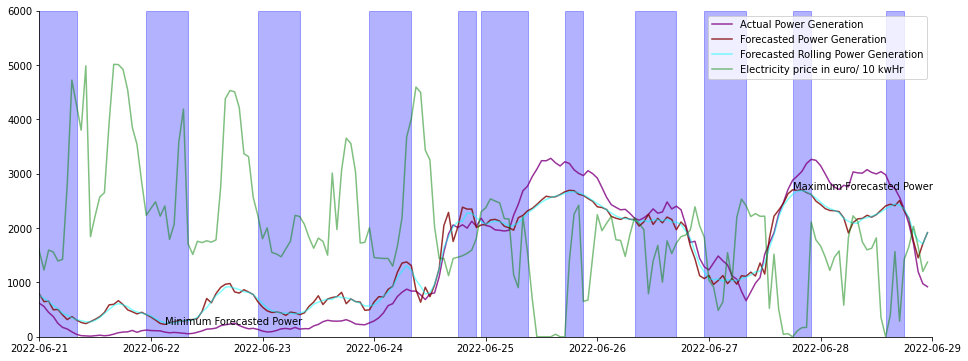

In [221]:
import matplotlib.pyplot as plt 
from matplotlib.pyplot import figure


highlights = highlightsCombined


highlights[0]=False
#highlights[1]=False
highlights[highlights]
print("The length of the highlights function is ",len(highlights[highlights]))

print(len(highlights))
#highlightsDiff = highlights
#highlightsCombined = () | hLP


forecastPlot=finalForecast
forecastPlot['index']=range(len(forecastPlot))
forecastPlot.index=range(len(forecastPlot))
forecastPlot.set_index('index')

ePriceWeatherMerged=ePriceWeatherMerged._convert(numeric=True)

forecastPlot= forecastPlot.reindex()


forecastPlot['predictedGeneration'] = forecastPred

fig, ax = plt.subplots(figsize=(2, 2))

plt.plot(ePriceWeatherMerged['date'],ePriceWeatherMerged[['ActualWind']],color = 'purple',label = 'Actual Power Generation', alpha = 0.8)

plt.plot(forecastPlot['date'],forecastPred,color = 'maroon',label = 'Forecasted Power Generation', alpha = 0.8)
plt.plot(forecastPlot['date'],forecastRoll,color = 'cyan',label = 'Forecasted Rolling Power Generation', alpha = 0.5)
plt.plot(forecastPlot['date'],ePriceWeatherMerged[['ImbalanceSettlementPrice']]*10,color = 'green',label = 'Electricity price in euro/ 10 kwHr ', alpha = 0.5)

forcastLen=len(forecastPlot['date'])
# highlight a time range

plt.legend(bbox_to_anchor=(1, 1))


# Removing spines
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)


#Showing the maxima minima
plt.annotate("Maximum Forecasted Power", (forecastPlot.date[(forecastpd == max(forecastpd))].values[0], forecastpd[(forecastpd == max(forecastpd))].values[0]))
plt.annotate("Minimum Forecasted Power", (forecastPlot.date[(forecastpd == min(forecastpd))].values[0], forecastpd[(forecastpd == min(forecastpd))].values[0]))
ax.set_xlim([datetime.date(2022, 6, 21), datetime.date(2022, 6, 29)])
ax.set_ylim([0, 6000])

#ax.axvspan(forecastPlot['date'][0],forecastPlot['date'][2], color="blue", alpha=0.3)
i=0
j=0
while i < forcastLen:
    #print("Itererating with I and J",i,j)
    j = 0

    while ((i+j) <= forcastLen) and ( highlights[i]):
        if (i+j != forcastLen) and (highlights[i+j]):
            j=j+1
        elif(i+j != forcastLen):
            #print("Plotting with i and j are given by",i,j,"And the date-time being",forecastPlot['date'][i])
            ax.axvspan(forecastPlot['date'][i-1],forecastPlot['date'][j+i], color="blue", alpha=0.3)
            i = i+j
        elif(i+j == forcastLen-1):
            #print("Plotting with i and j are given by",i,j,"And the date-time being",forecastPlot['date'][i])
            ax.axvspan(forecastPlot['date'][i-1],forecastPlot['date'][i+1], color="blue", alpha=0.3)
            i = i+j
        else:
            #print("Plotting with i and j are given by",i,j,"And the date-time being",forecastPlot['date'][i])
            ax.axvspan(forecastPlot['date'][i-1],forecastPlot['date'][i], color="blue", alpha=0.3)
            i = i+j
    i=i+1
        
forecastPlot['rawTemp']=rawTemp
forecastPlot.to_csv(path_or_buf='./dashboard/chargeTimeDashboard/forecastPlot.csv',index=False)

#plt.legend(bbox_to_anchor=(0.89, 0.98))
plt.legend(loc=1)

fig = plt.gcf()
fig.set_size_inches(16, 6)
fig.savefig('./dashboard/chargeTimeDashboard/forecast.png', dpi=100)


In [222]:
import math as ma
highlightsBesidePeakWind = ePriceWeatherMerged['highlightsBesidePeakWind']
highlightsS = ePriceWeatherMerged['highlights']
highlightsHourlyMorning = ePriceWeatherMerged['highlightsHourlyMorning']



# Finding the mean settlement price over the complete period
meanEPrice=ePriceWeatherMerged.ImbalanceSettlementPrice.mean()
print("Mean electricity price given by",meanEPrice)


eMinWindPeak=ePriceWeatherMerged.ImbalanceSettlementPrice[highlightsS].mean()
print("The average cost of electricity at peak wind power production is given by ", eMinWindPeak)


eMinWindPeak=ePriceWeatherMerged.ImbalanceSettlementPrice[highlightsBesidePeakWind].mean()
print("The average cost of electricity of the hours around peak wind power production ", eMinWindPeak)


eMinHoursMorning = ePriceWeatherMerged.ImbalanceSettlementPrice[highlightsHourlyMorning].mean()
print("The average cost of electricity at early morning times  ", eMinHoursMorning)

meanCombinedPrice = ePriceWeatherMerged.ImbalanceSettlementPrice[highlightsCombined].mean()
print("The mean combined average cost is given by  ", meanCombinedPrice)

Mean electricity price given by 191.4080290456432
The average cost of electricity at peak wind power production is given by  162.72636363636366
The average cost of electricity of the hours around peak wind power production  138.9906153846154
The average cost of electricity at early morning times   175.9344375
The mean combined average cost is given by   171.38226744186048


Mean electricity price given by 191.4080290456432 

The average cost of electricity at peak wind power production is given by  162.72636363636366

The average cost of electricity of the hours around peak wind power production  138.9906153846154

The average cost of electricity at early morning times   175.9344375

The mean combined average cost is given by   171.38226744186048

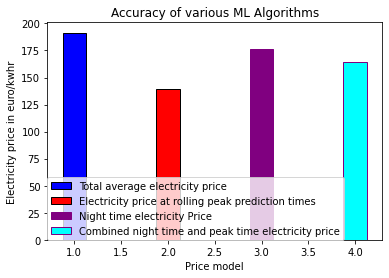

In [212]:
import numpy as np
import matplotlib.pyplot as plt




width = 0.25


plt.bar(x = 1, height = meanEPrice, color = 'b', width = width, edgecolor = 'black',label='Total average electricity price')
plt.bar(x = 2, height = eMinWindPeak, color = 'r', width = width, edgecolor = 'black',label='Electricity price at rolling peak prediction times')
plt.bar(x = 3, height = eMinHoursMorning, color = 'purple', width = width, edgecolor = 'purple',label='Night time electricity Price')

plt.bar(x = 4, height = meanCombinedPrice, color = 'cyan', width = width, edgecolor = 'purple',label='Combined night time and peak time electricity price')

plt.xlabel("Price model")
plt.ylabel("Electricity price in euro/kwhr")
plt.title("Accuracy of various ML Algorithms")

# plt.grid(linestyle='--')
#plt.xticks(r + width/2,['2018','2019','2020','2021'])
plt.legend(loc=[0,0])
plt.savefig('MLImages/ModelCosts.png')
plt.show()
